# 2ND TEAM  -  Project A : (Investment Comparison)

##### Team Members :
-  Erfan Fahimnia  
-  Hadi Behsaz  
-  Ali Bazrkar

## Import Libraries

In [126]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Data Preparation

In [127]:
# Define the tickers for each asset
tickers = {
    'Oil': 'CL=F',            # Crude Oil WTI
    'Gold': 'GC=F',           # Gold Futures
    'Dollar Index': 'DX-Y.NYB',  # US Dollar Index
    'Bitcoin': 'BTC-USD'      # Bitcoin USD
}

# Create an empty dictionary to store dataframes
dataframes = {}

# Set the start and end dates
start_date = '2015-01-01'
end_date = '2024-01-01'

# Download the data for each asset
for asset, ticker in tickers.items():
    data = yf.download(ticker, start=start_date, end=end_date)
    if 'Close' in data.columns:  # Ensure we have 'Close' data
        data['Asset'] = asset
        dataframes[asset] = data[['Close']].rename(columns={'Close': f'{asset} Price'})
    else:
        print(f"Warning: No 'Close' data for {asset} (Ticker: {ticker})")

# Merge the dataframes on Date, handle missing values if necessary
merged_data = pd.concat(dataframes.values(), axis=1, join='inner')

# Save the merged data to a CSV file
merged_data.to_csv('merged_asset_prices.csv')
# Read the CSV and parse dates
data = pd.read_csv("merged_asset_prices.csv", parse_dates=True, index_col=0)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Investment values (Close) all in one plot :

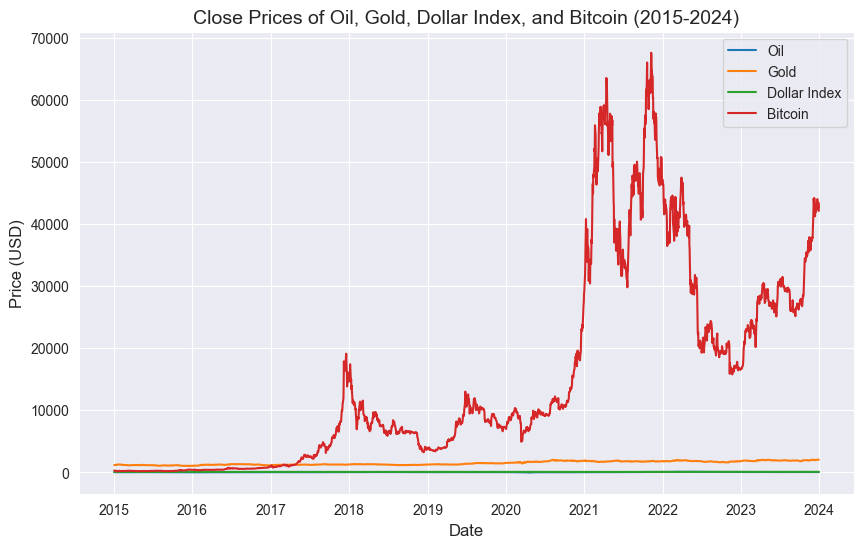

In [128]:
# Plot the close prices for all assets on a single figure
plt.figure(figsize=(10, 6))
for asset in tickers.keys():
    plt.plot(merged_data[f'{asset} Price'], label=asset)

# Add labels and title
plt.title('Close Prices of Oil, Gold, Dollar Index, and Bitcoin (2015-2024)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

## Standardized Values for better comparison :

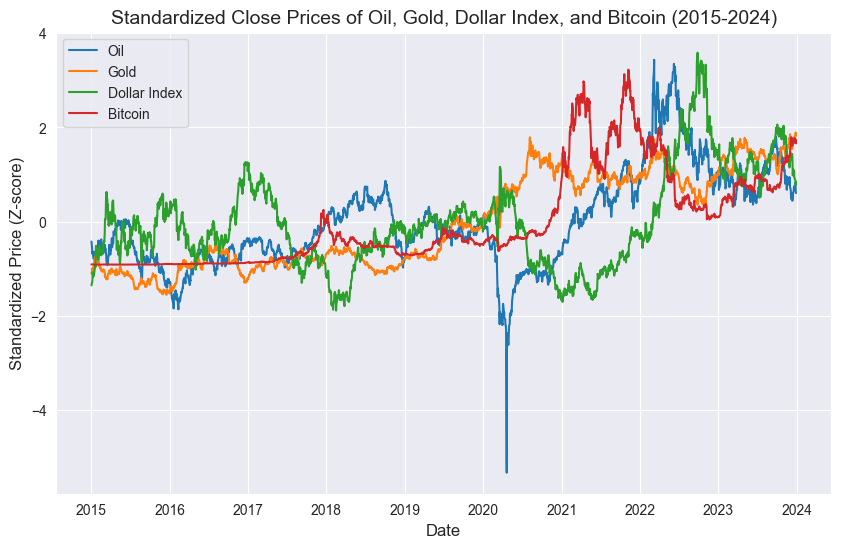

In [129]:
# standardize the data -> mean 0, std 1
standardized_data = (merged_data - merged_data.mean()) / merged_data.std()

# standardized data plot
plt.figure(figsize=(10, 6))
for asset in tickers.keys():
    plt.plot(standardized_data[f'{asset} Price'], label=asset)

# Add labels and title
plt.title('Standardized Close Prices of Oil, Gold, Dollar Index, and Bitcoin (2015-2024)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Standardized Price (Z-score)', fontsize=12)
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

## Standardized + EWMA (500)

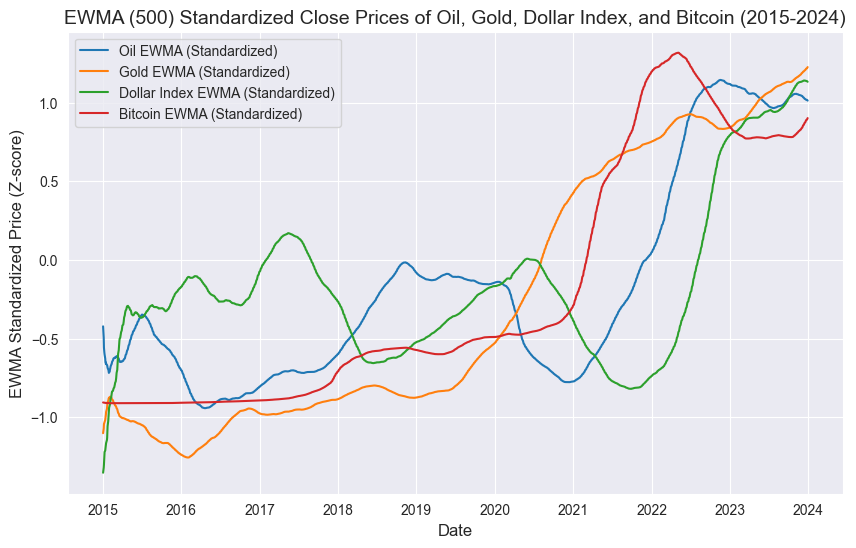

In [130]:
# Apply standardized EWM average
ewma_standardized_data = standardized_data.ewm(span=500).mean()

# Plot the EWMA of the standardized data
plt.figure(figsize=(10, 6))
for asset in tickers.keys():
    plt.plot(ewma_standardized_data[f'{asset} Price'], label=f'{asset} EWMA (Standardized)')

# Add labels and title
plt.title('EWMA (500) Standardized Close Prices of Oil, Gold, Dollar Index, and Bitcoin (2015-2024)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('EWMA Standardized Price (Z-score)', fontsize=12)
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

## Calculating Daily Returns

In [131]:
# Calculate daily returns
returns = data.pct_change().dropna()

## Histogram Plot

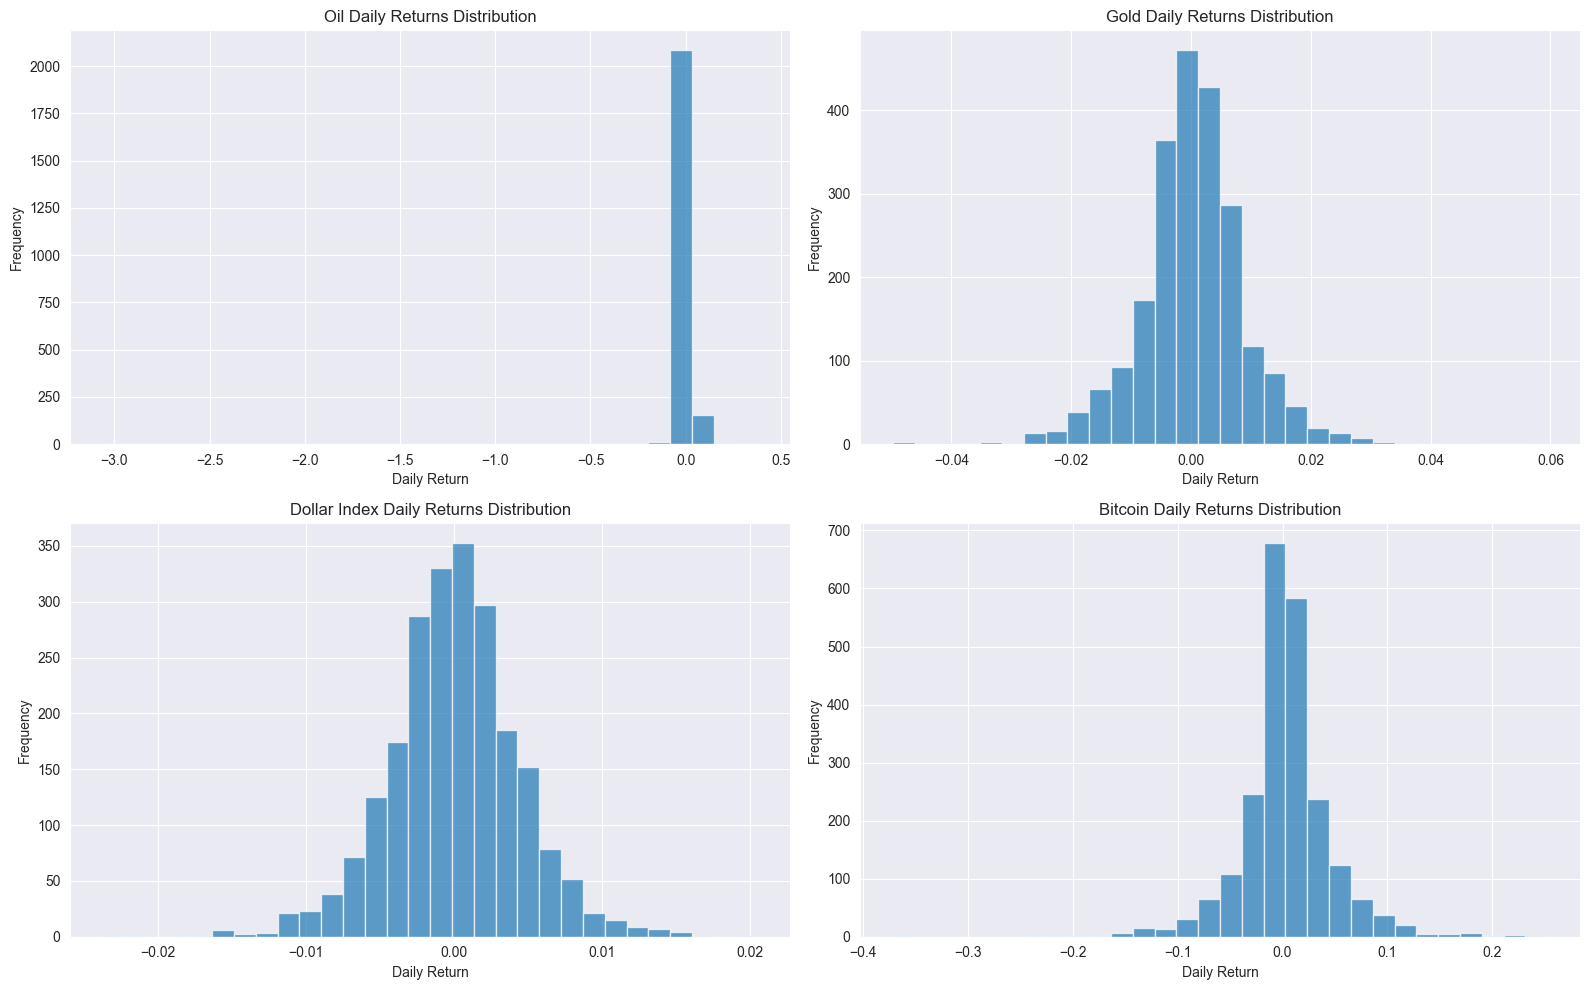

In [132]:
# Set the plot size for histograms
plt.figure(figsize=(16, 10))

# Create histograms for each asset's daily returns
for i, asset in enumerate(tickers.keys(), 1):
    plt.subplot(2, 2, i)
    plt.hist(returns[f'{asset} Price'], bins=30, alpha=0.7)
    plt.title(f'{asset} Daily Returns Distribution')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Correlation

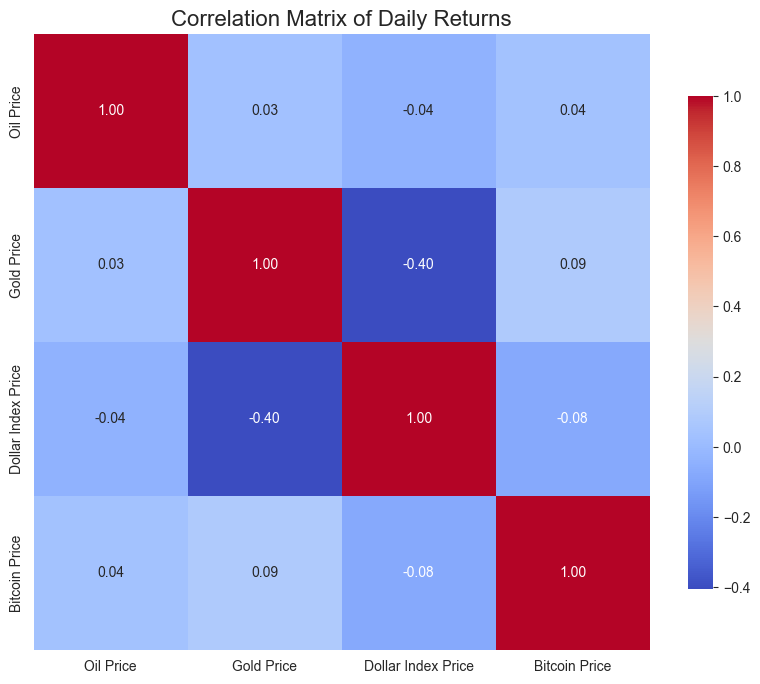

In [133]:
# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = returns.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.show()

## Scatter Plot

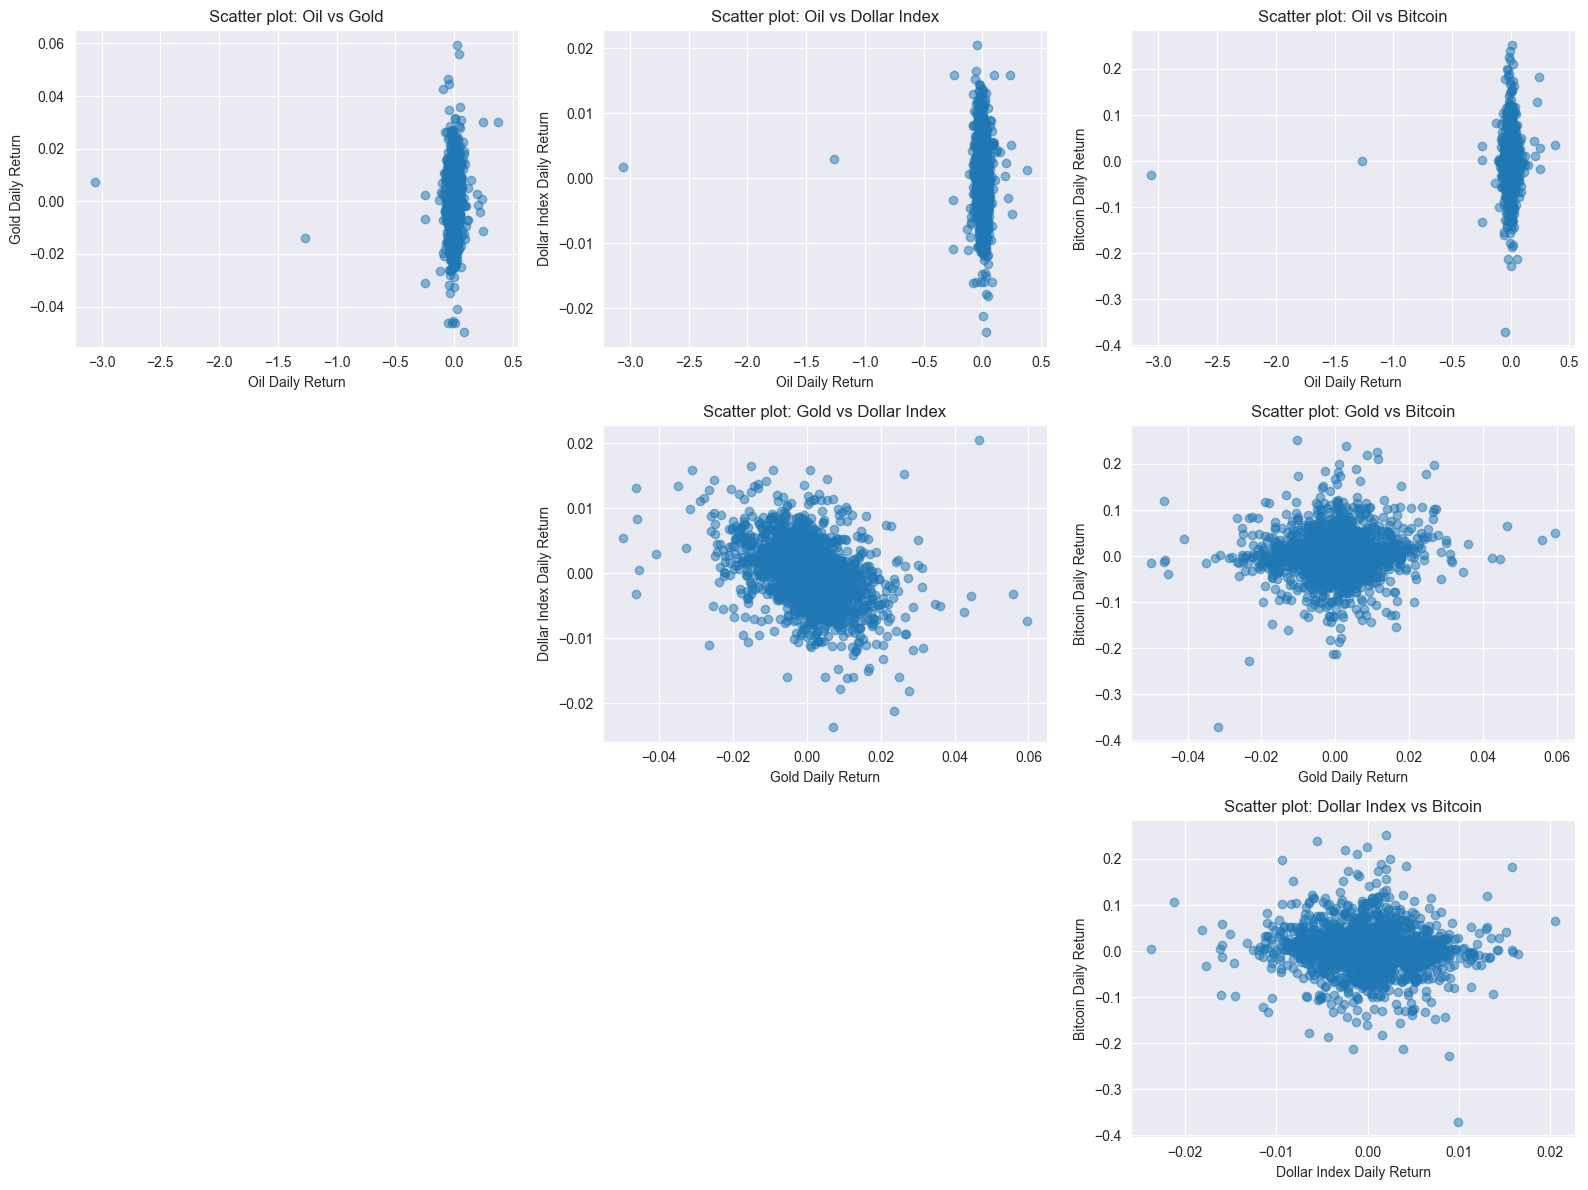

In [134]:
# Scatter plot pairs
plt.figure(figsize=(16, 12))
pairwise_assets = list(tickers.keys())
for i in range(len(pairwise_assets)):
    for j in range(i + 1, len(pairwise_assets)):
        plt.subplot(3, 3, i * (len(pairwise_assets)-1) + j)
        plt.scatter(returns[f'{pairwise_assets[i]} Price'], returns[f'{pairwise_assets[j]} Price'], alpha=0.5)
        plt.xlabel(f'{pairwise_assets[i]} Daily Return')
        plt.ylabel(f'{pairwise_assets[j]} Daily Return')
        plt.title(f'Scatter plot: {pairwise_assets[i]} vs {pairwise_assets[j]}')

plt.tight_layout()
plt.show()

## Weekdays Comparison - Yearly Calculate

In [135]:
# Add a 'Weekday' column to merged_data, where 0=Monday, 1=Tuesday, ..., 6=Sunday
merged_data['Weekday'] = merged_data.index.weekday

# Map day numbers to day names
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Define colors for weekdays
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

# Create a subplot grid with 4 rows and 1 column (one plot per asset)
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=list(tickers.keys()))

# Loop through each asset and create a subplot for each one
for i, asset in enumerate(tickers.keys(), start=1):
    # Add a trace for each weekday
    for j in range(7):
        day_data = merged_data[merged_data['Weekday'] == j]
        if not day_data.empty:  # Ensure data exists for this weekday
            fig.add_trace(go.Scatter(
                x=day_data.index, 
                y=day_data[f'{asset} Price'],
                mode='lines',
                showlegend=False,  # Disable legend for individual lines
                line=dict(color=colors[j])  # Apply color for each day
            ), row=i, col=1)

# Add traces to the legend to represent each weekday
for j in range(7):
    fig.add_trace(go.Scatter(
        x=[None],  # No actual data, just for legend
        y=[None],
        mode='lines',
        name=weekdays[j],  # Add weekday name to the legend
        line=dict(color=colors[j])  # Use the corresponding color
    ))

# Update layout for better visualization
fig.update_layout(
    title="Asset Prices by Weekday",
    height=1000,
    showlegend=True
)

# Show the plot
fig.show()


In [136]:
# Calculate the mean of daily close prices for each asset
daily_means = merged_data.groupby('Weekday').mean()

# Print the mean close price for each asset by weekday
print("Mean Close Price for Each Asset by Weekday:")
for asset in tickers.keys():
    print(f"\n{asset}:")
    print(daily_means[[f'{asset} Price']])

Mean Close Price for Each Asset by Weekday:

Oil:
         Oil Price
Weekday           
0        60.021480
1        60.543548
2        60.466237
3        60.480980
4        60.785320

Gold:
          Gold Price
Weekday             
0        1513.578522
1        1515.971395
2        1516.519141
3        1516.588451
4        1515.946799

Dollar Index:
         Dollar Index Price
Weekday                    
0                 97.373437
1                 97.397957
2                 97.391161
3                 97.361046
4                 97.424415

Bitcoin:
         Bitcoin Price
Weekday               
0         15050.644998
1         15074.983164
2         15159.110615
3         15013.041887
4         15009.687809


## Weekdays Comparison - Last Year Calculate

In [137]:
# Filter data for the last year (2023-2024)
last_year_data = merged_data[(merged_data.index >= '2023-01-01') & (merged_data.index <= '2024-01-01')]

# Map day numbers to day names
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Define colors for weekdays
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

# Create a subplot grid with 4 rows and 1 column (one plot per asset)
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=list(tickers.keys()))

# Loop through each asset and create a subplot for each one
for i, asset in enumerate(tickers.keys(), start=1):
    # Add a trace for each weekday
    for j in range(7):
        day_data = last_year_data[last_year_data['Weekday'] == j]
        if not day_data.empty:  # Ensure data exists for this weekday
            fig.add_trace(go.Scatter(
                x=day_data.index, 
                y=day_data[f'{asset} Price'],
                mode='lines',
                showlegend=False,  # Disable legend for individual lines
                line=dict(color=colors[j])  # Apply color for each day
            ), row=i, col=1)

# Add traces to the legend to represent each weekday
for j in range(7):
    fig.add_trace(go.Scatter(
        x=[None],  # No actual data, just for legend
        y=[None],
        mode='lines',
        name=weekdays[j],  # Add weekday name to the legend
        line=dict(color=colors[j])  # Use the corresponding color
    ))

# Update layout for better visualization
fig.update_layout(
    title="Asset Prices by Weekday (2023-2024)",
    height=1000,
    showlegend=True
)

# Show the plot
fig.show()


In [138]:
# Calculate the mean of daily close prices for each asset
daily_means = last_year_data.groupby('Weekday').mean()

# Print the mean close price for each asset by weekday
print("Mean Close Price for Each Asset by Weekday:")
for asset in tickers.keys():
    print(f"\n{asset}:")
    print(daily_means[[f'{asset} Price']])

Mean Close Price for Each Asset by Weekday:

Oil:
         Oil Price
Weekday           
0        77.984889
1        77.856863
2        77.331538
3        77.232353
4        77.630784

Gold:
          Gold Price
Weekday             
0        1942.655556
1        1941.705880
2        1942.773076
3        1942.670582
4        1944.027447

Dollar Index:
         Dollar Index Price
Weekday                    
0                103.462889
1                103.473333
2                103.430385
3                103.415294
4                103.452353

Bitcoin:
         Bitcoin Price
Weekday               
0         28917.181163
1         28784.288105
2         28964.890888
3         28666.945121
4         28973.247204


## Weekdays Comparison - Last Month Calculate

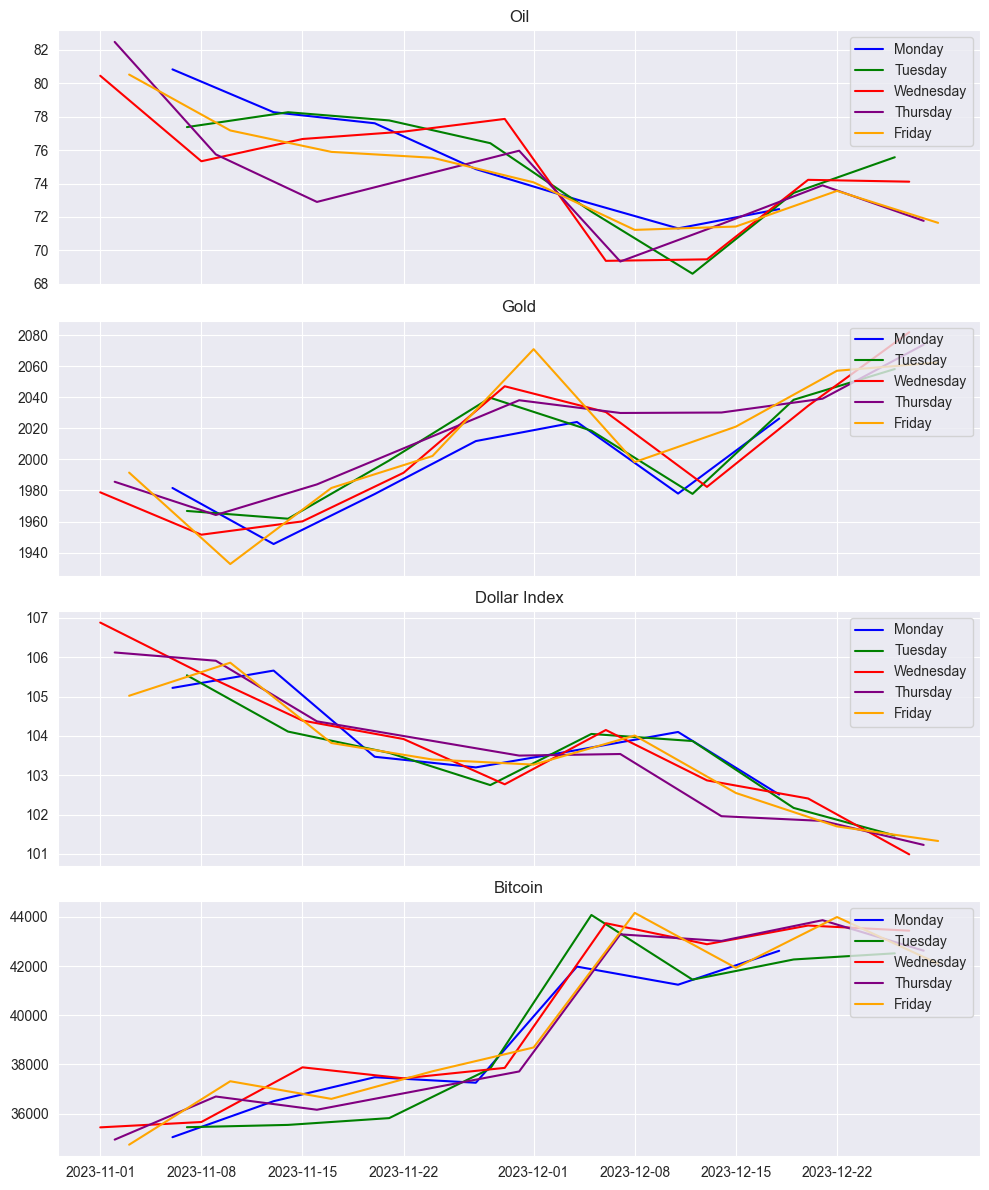

In [139]:
# Filter data for the last two months (November 2023 to January 2024)
last_month_data = merged_data[(merged_data.index >= '2023-11-01') & (merged_data.index <= '2024-01-01')]

# Map day numbers to day names
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Define colors for weekdays
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

# Create subplots: 4 rows for each asset
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Loop through each asset and plot the data for each weekday
for i, (asset, ax) in enumerate(zip(tickers.keys(), axes)):
    for j in range(7):
        # Filter data for the current weekday
        day_data = last_month_data[last_month_data['Weekday'] == j]
        if not day_data.empty:
            ax.plot(day_data.index, day_data[f'{asset} Price'], label=weekdays[j], color=colors[j])
    
    ax.set_title(asset)
    ax.legend(loc='upper right')  # Add legend to each subplot

# Set common labels
plt.tight_layout()

# Display the plot
plt.show()

In [140]:
# Calculate the mean of daily close prices for each asset
daily_means = last_month_data.groupby('Weekday').mean()

# Print the mean close price for each asset by weekday
print("Mean Close Price for Each Asset by Weekday:")
for asset in tickers.keys():
    print(f"\n{asset}:")
    print(daily_means[[f'{asset} Price']])

Mean Close Price for Each Asset by Weekday:

Oil:
         Oil Price
Weekday           
0        75.481429
1        74.968751
2        74.952223
3        74.204999
4        74.561111

Gold:
          Gold Price
Weekday             
0        1992.142857
1        2007.562515
2        2006.455553
3        2018.112473
4        2013.088881

Dollar Index:
         Dollar Index Price
Weekday                    
0                103.971429
1                103.441251
2                103.774444
3                103.558751
4                103.440000

Bitcoin:
         Bitcoin Price
Weekday               
0         38874.045759
1         39368.487793
2         39777.359809
3         39789.065918
4         39693.963542
